In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Data overview

Cindicator is a smart asset management fund. Thousands of analysts answer questions about market movements, their predictions are aggregated and trades are made. 

This is an example of one of those questions where an analyst is asked to predict a probability for a described event:

<img src="question_example.png">



The data was generated by asking that kind of questions over time.

Multiple users answer each question.

Your task is to build a model that will aggregate users' guesses and make a prediction if an event will actually happen. 

This notebook will help you understand the structure of the data.

On Dbrain the data is split into four parts:

1) `preview dataset` which is the only one that you are able to download

2) `train dataset` that is used to train your model on our servers

3) `public test dataset` which is used for computing public leaderboard scores

4) `private test dataset` which is used for computing private leaderboard scores after the contest is complete. Prizes are distributed based on private leaderboard rank.
    
Dataset structure is exactly the same in each case. Here we explore the preview dataset.

The Cindicator dataset is split into multiple `.csv` files. Each file contains data related to questions that ended at the same time. 

You may also encounter a file called `markup.json` in the data directory, it has binary target labels for every csv and question which are the same as target labels in the `question_answer` column in csvs.

In [2]:
data_dir = 'data/preview/'

In [3]:
csv_paths = sorted([os.path.join(data_dir, fname) for fname in os.listdir(data_dir) 
                    if fname.endswith('.csv')])

Let's load all the data, aggregate it into a single dataframe and look at the fields.

In [4]:
df = pd.concat(pd.read_csv(fname, index_col=0) for fname in csv_paths)

In [5]:
df.sample(3)

,question_id,started_question_time,finished_question_time,target_date,user_id,user_created_at,user_country,user_answer,user_answer_created_at,question_ticker,user_birthday,user_gender,question_answer,window_id
717267,487,2018-03-08 00:00:00.000000,2018-03-09 00:00:00.000000,2018-04-02,42882,2018-01-05 21:11:56.128181,801a6851-bd7d-4f27-bb43-d708ab704f71,1.00,2018-03-08 18:53:47.656209,238,NaN,1.0,0,98
479038,1636,2018-02-15 00:00:00.000000,2018-02-15 00:00:00.000000,2018-02-28,36752,2017-12-13 08:04:39.638945,88b7a618-2694-4184-967c-1e2b2c1b5516,0.82,2018-02-15 12:15:05.722869,104,2001-02-03 00:00:00.000000,0.0,0,76
22434,1549,2017-12-12 00:00:00.000000,2017-12-13 00:00:00.000000,2018-12-12,41726,2017-08-23 18:52:39.901684,9220b14b-93f0-4abb-84fc-794f808e27b3,1.00,2017-12-12 14:34:30.618596,71,NaN,1.0,1,13


In [6]:
print('Preview dataset info')
print('Unique questions:', df['question_id'].nunique())
print('Unique users:', df['user_id'].nunique())
print('Total predictions:', df.shape[0])

Preview dataset info
Unique questions: 664
Unique users: 39263
Total predictions: 739850


Each row contains an answer to a question from a single analyst.

`question_id` - unique id of the question that the analyst answered

`started_question_time` - time of beginning of answer acceptance for the question

`finished_question_time` - time of ending of answer acceptance for the question

`target_date` - questioned date

`user_id` - unique user (analyst) id

`user_answer` - probability score assigned by user to event in question. Each user can only answer a given question once.

`user_created_at`, `user_country`, `user_birthday`, `user_gender`, `user_answer_created_at` - self-explanatory, some of the data is obfuscated

`question_ticker` - id of the financial asset in question 

`question_answer` - true outcome of the question, that is what you are predicting!

`window_id` - technical field, derived from `finished_question_time`. All questions that are finished at the same time have same `window_id`

Your task is to predict the `question_answer` for each `question_id` based on all analyst predictions. 

# Simple exploration

Well you can guess which analyst gender is labeled one and which is labeled zero. You can even try to infer what is the gender 2.0. Not that it is of much use though.

In [7]:
df.groupby('user_gender')['user_gender'].apply(len)

user_gender
0.0     24584
1.0    430269
2.0       533
Name: user_gender, dtype: int64

Some of the fields have missing values, most commonly birthday and gender of user.

In [8]:
missing_nums = df.isnull().sum()
print(missing_nums.iloc[missing_nums.nonzero()[0]])

target_date       40389
user_country       8547
user_birthday    435860
user_gender      284464
dtype: int64


The whole range of possible answers is limited by 2 significant digits after the dot.

In [9]:
print(df.user_answer.nunique())
print(sorted(df.user_answer.unique())[:5])

100
[0.0, 0.01, 0.02, 0.03, 0.04]


Some users seem to really like binary predictions and round probabilities. You surely shouldn't follow this strategy as it will be penalized by logloss.

You can also see that users are heavily biased towards positive answers in general whereas the outcomes happen to be negative much more often than positive.

These biases are [well](https://en.wikipedia.org/wiki/Response_bias#Extreme_responding)-[known](https://en.wikipedia.org/wiki/Acquiescence_bias).

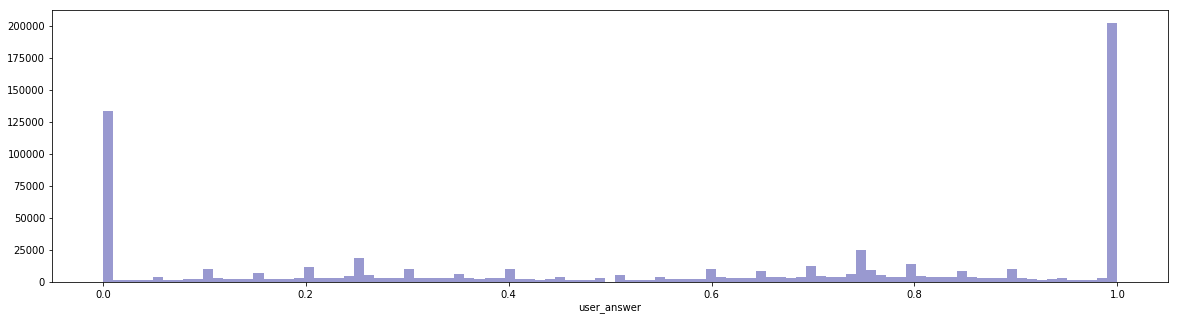

In [10]:
plt.figure(figsize=(20, 5))
distplot = sns.distplot(df.user_answer, bins=101, color='darkblue', kde=False)

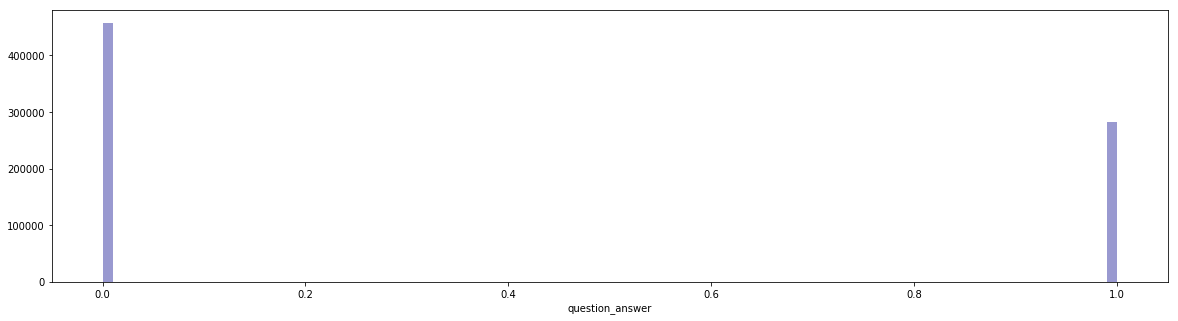

In [11]:
plt.figure(figsize=(20, 5))
distplot = sns.distplot(df['question_answer'], bins=101, color='darkblue', kde=False)

Compute the number of answered questions for each user

In [12]:
user_answered_counts = df.set_index('user_id').index.value_counts().sort_index()

Compute linear correlations between prediction and ground truth for each user

In [13]:
user_corrs = df.groupby('user_id')[['user_answer', 'question_answer']].corr()
# remove multiindex
user_corrs = user_corrs.iloc[0::2, -1].reset_index(level=[1])['question_answer']
# users with only one prediction got NaN and it's OK

The following plot leads to several insights:

1) There are awesome individuals who answered a huge load of questions and did much better than average on most of them. You can try to base your model on their predictions particularly.

2) There are also some people who score consistently worse than average and so (1 - their_prediction) may serve you a good job.

3) The events are not very predictable on average (even the best users with a high number of answered questions never have a correlation with ground truth of more than 0.5)

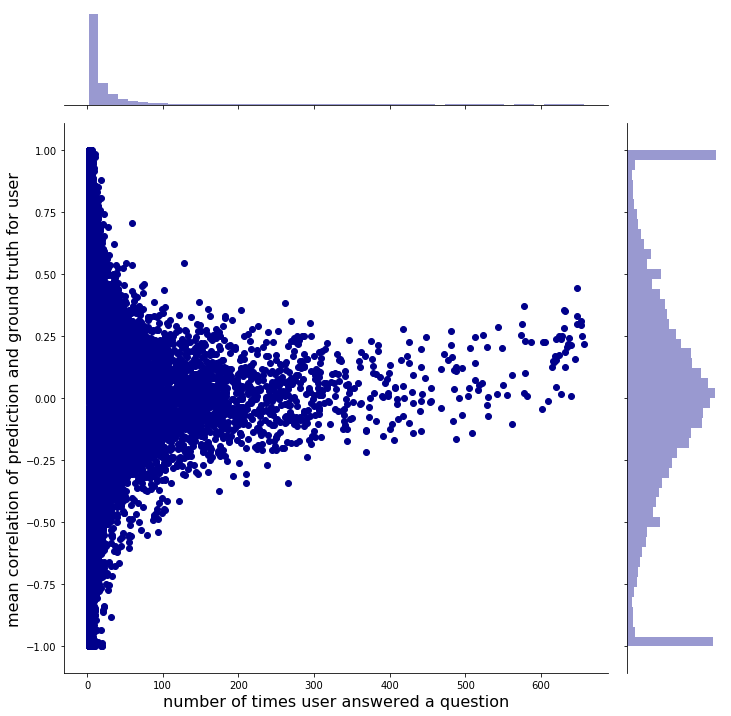

In [14]:
jointplot = sns.jointplot(user_answered_counts, user_corrs, height=10, color='darkblue')
jointplot = jointplot.set_axis_labels('number of times user answered a question',
                                      'mean correlation of prediction and ground truth for user',
                                      fontsize=16)

Always keep in mind that the relationship between user predictions and true answers on test may unfortunately be significantly different from the same kind of relationship on train due to the nature of the data.

Because of this fact it can be critical to be able to learn on-the-fly with update() (see training example).

One more insight: question_ticker (financial asset in question) may repeat again on test set. If a popular question_ticker repeats, you already have a prior on the answer as shown below.

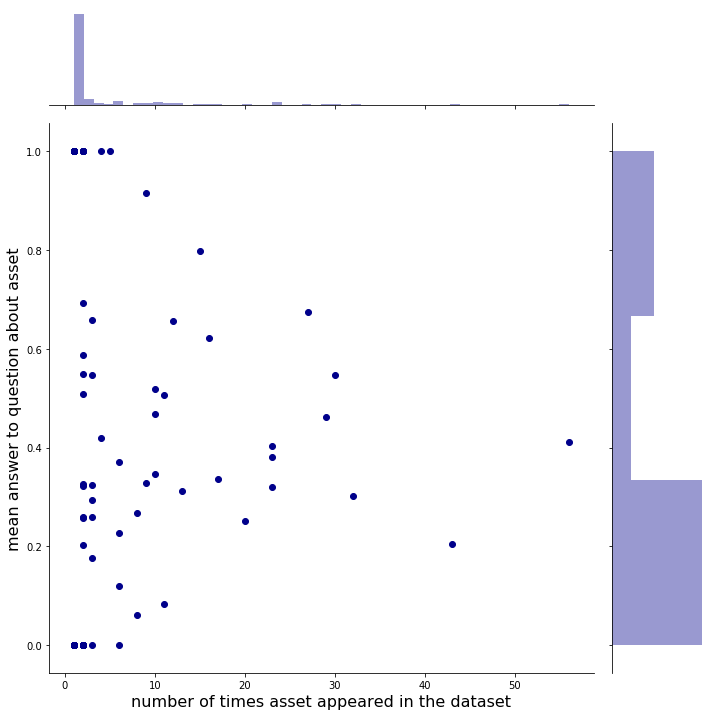

In [15]:
ticker_question_counts = df.groupby('question_ticker')['question_id'].unique().apply(len)
ticker_mean_answers = df.groupby('question_ticker')['question_answer'].mean()
jointplot = sns.jointplot(ticker_question_counts, ticker_mean_answers, height=10, color='darkblue')
jointplot = jointplot.set_axis_labels('number of times asset appeared in the dataset',
                                      'mean answer to question about asset',
                                      fontsize=16)